In [ ]:
!nvidia-smi

Mon Apr 12 04:20:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.0166964days (1442.57sec)


In [ ]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [ ]:
import sys
sys.path.append('/content/custom_ImageNet')

In [ ]:
import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/resize_30random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/base/custom_ImagenetTest2.zip" /content/

In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!7z x resize_30random_ImagenetTrain.zip

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!mv "content/resize_ImagenetTrain" ../content

In [ ]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [ ]:
!unzip -nq "custom_ImagenetTest2.zip"

In [ ]:
rootpathTrain ='resize_ImagenetTrain/'
rootpathTest ='custom_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

424704

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


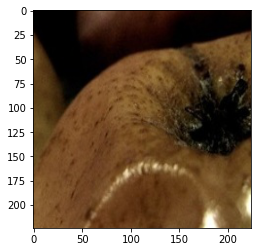

In [ ]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 30

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Network model

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.mobilenet_v2(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [ ]:
# Optimization setting
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_corrects = 0  # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_corrects)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_corrects / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
        print('-------------')

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [ ]:
LOAD_STATE = False
EPOCH = 40             # This values need to check the latest tar ffile name with epoch.
name = "07std_mobilenet"
folder_name = "mobilenet"

if LOAD_STATE:
    stats=[];
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model = net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [ ]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, "mobilenet", DEBUG)

Epoch 1/30
-------------



335809
train Loss: 0.0208 Acc: 79.0690



91305
val Loss: 0.0137 Acc: 85.9940
-------------
Epoch 2/30
-------------



372456
train Loss: 0.0121 Acc: 87.6978



96752
val Loss: 0.0087 Acc: 91.1242
-------------
Epoch 3/30
-------------



386842
train Loss: 0.0086 Acc: 91.0851



99612
val Loss: 0.0060 Acc: 93.8178
-------------
Epoch 4/30
-------------



395075
train Loss: 0.0068 Acc: 93.0236



100548
val Loss: 0.0052 Acc: 94.6994
-------------
Epoch 5/30
-------------



401743
train Loss: 0.0052 Acc: 94.5936



102052
val Loss: 0.0037 Acc: 96.1159
-------------
Epoch 6/30
-------------



405625
train Loss: 0.0043 Acc: 95.5077



102190
val Loss: 0.0036 Acc: 96.2459
-------------
Epoch 7/30
-------------



408606
train Loss: 0.0036 Acc: 96.2096



102717
val Loss: 0.0031 Acc: 96.7422
-------------
Epoch 8/30
-------------



410562
train Loss: 0.0032 Acc: 96.6702



103274
val Loss: 0.0027 Acc: 97.2668
-------------
Epoch 9/30
-------------



412722
train Loss: 0.0027 Acc: 97.1787



103593
val Loss: 0.0024 Acc: 97.5672
-------------
Epoch 10/30
-------------



414414
train Loss: 0.0023 Acc: 97.5771



103862
val Loss: 0.0022 Acc: 97.8206
-------------
Epoch 11/30
-------------



415648
train Loss: 0.0020 Acc: 97.8677



104128
val Loss: 0.0019 Acc: 98.0711
-------------
Epoch 12/30
-------------



416628
train Loss: 0.0018 Acc: 98.0984



104145
val Loss: 0.0019 Acc: 98.0871
-------------
Epoch 13/30
-------------



417410
train Loss: 0.0016 Acc: 98.2826



104367
val Loss: 0.0017 Acc: 98.2962
-------------
Epoch 14/30
-------------



417804
train Loss: 0.0015 Acc: 98.3753



104578
val Loss: 0.0015 Acc: 98.4950
-------------
Epoch 15/30
-------------



418636
train Loss: 0.0013 Acc: 98.5712



104661
val Loss: 0.0014 Acc: 98.5731
-------------
Epoch 16/30
-------------



419139
train Loss: 0.0012 Acc: 98.6897



104761
val Loss: 0.0014 Acc: 98.6673
-------------
Epoch 17/30
-------------



419542
train Loss: 0.0011 Acc: 98.7846



104662
val Loss: 0.0015 Acc: 98.5741
-------------
Epoch 18/30
-------------



419938
train Loss: 0.0010 Acc: 98.8778



104827
val Loss: 0.0013 Acc: 98.7295
-------------
Epoch 19/30
-------------



420278
train Loss: 0.0010 Acc: 98.9579



104986
val Loss: 0.0012 Acc: 98.8792
-------------
Epoch 20/30
-------------



420465
train Loss: 0.0009 Acc: 99.0019



104962
val Loss: 0.0012 Acc: 98.8566
-------------
Epoch 21/30
-------------



420764
train Loss: 0.0009 Acc: 99.0723



105019
val Loss: 0.0011 Acc: 98.9103
-------------
Epoch 22/30
-------------



421178
train Loss: 0.0008 Acc: 99.1698



105040
val Loss: 0.0011 Acc: 98.9301
-------------
Epoch 23/30
-------------



421263
train Loss: 0.0008 Acc: 99.1898



104987
val Loss: 0.0012 Acc: 98.8802
-------------
Epoch 24/30
-------------



421438
train Loss: 0.0007 Acc: 99.2310



105080
val Loss: 0.0010 Acc: 98.9678
-------------
Epoch 25/30
-------------



421453
train Loss: 0.0007 Acc: 99.2345



104943
val Loss: 0.0012 Acc: 98.8387
-------------
Epoch 26/30
-------------



421763
train Loss: 0.0006 Acc: 99.3075



105048
val Loss: 0.0011 Acc: 98.9376
-------------
Epoch 27/30
-------------



421910
train Loss: 0.0006 Acc: 99.3421



105193
val Loss: 0.0010 Acc: 99.0742
-------------
Epoch 28/30
-------------



422167
train Loss: 0.0005 Acc: 99.4026



105112
val Loss: 0.0011 Acc: 98.9979
-------------
Epoch 29/30
-------------



422036
train Loss: 0.0006 Acc: 99.3718



105148
val Loss: 0.0010 Acc: 99.0318
-------------
Epoch 30/30
-------------



422215
train Loss: 0.0006 Acc: 99.4139



105246
val Loss: 0.0009 Acc: 99.1241
-------------
Lowest training loss 0.0005481520781789913
Lowest validation loss 0.0009098587261407058
Highest training accuracy 99.41394477094634
Highest validation accuracy 99.124095840868
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/07std_mobilenet_Loss _.png07std_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/07std_mobilenet_Accuracy _.png07std_mobilenet_Accuracy _.png


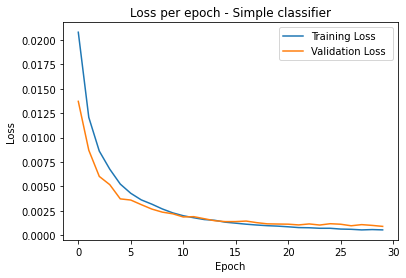

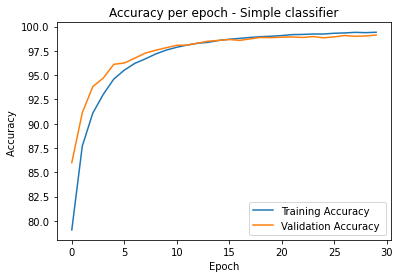

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 1.1330 
Testing Accuracy: 1643/2000 (82.15%)
apple Class Accuracy: 70/100 (70.00%)
banana Class Accuracy: 83/100 (83.00%)
bear Class Accuracy: 89/100 (89.00%)
bell_pepper Class Accuracy: 76/100 (76.00%)
bird Class Accuracy: 82/100 (82.00%)
broccoli Class Accuracy: 81/100 (81.00%)
cat Class Accuracy: 67/100 (67.00%)
cauliflower Class Accuracy: 85/100 (85.00%)
cow Class Accuracy: 84/100 (84.00%)
dog Class Accuracy: 79/100 (79.00%)
elephant Class Accuracy: 99/100 (99.00%)
fox Class Accuracy: 83/100 (83.00%)
goat Class Accuracy: 74/100 (74.00%)
horse Class Accuracy: 76/100 (76.00%)
mashed_potato Class Accuracy: 91/100 (91.00%)
orange Class Accuracy: 78/100 (78.00%)
pineapple Class Accuracy: 87/100 (87.00%)
pomegranate Class Accuracy: 85/100 (85.00%)
tomato Class Accuracy: 80/100 (80.00%)
zebra Class Accuracy: 94/100 (94.00%)
Classifier has Acc=0.822 P=0.822 R=0.832 F1=0.823
               precision    recall  f1-score   support

        apple       0.80      0.70      0.75     

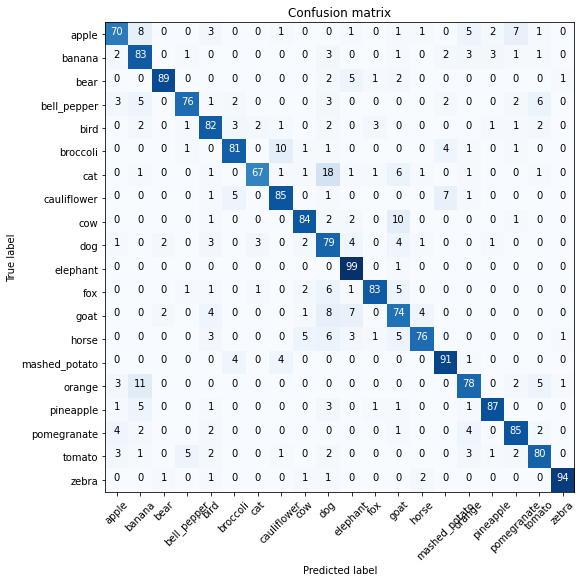

In [ ]:
result = test_model(best_model, criterion, name)